In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import binomial

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Thompson(ベルヌーイ分布の場合)

In [4]:
#argparms=[当たりの回数,外れの回数,ベータ分布のalpha,ベータ分布のbeta]
def thompson_bernoulli(armparams,T,ps):
    reward=0
    cumulative_reward=[]
    
    for i in range(1,T):
        #ベータ分布よりランダムサンプリング
        thetas = [np.random.beta(a=armparams[index,2], b=armparams[index,3]) for index in range(len(ps))]
        #値が最大のアームを選択
        index=max(enumerate(thetas), key=lambda x: x[1])[0]
        result = binomial(n=1, p=ps[index])
        if result == 1:
            armparams[index,0]+=1
            armparams[index,2]+=1
        else:
            armparams[index,1]+=1
            armparams[index,3]+=1
        
        reward+=result
        cumulative_reward.append(reward)
    return pd.Series(cumulative_reward)/T

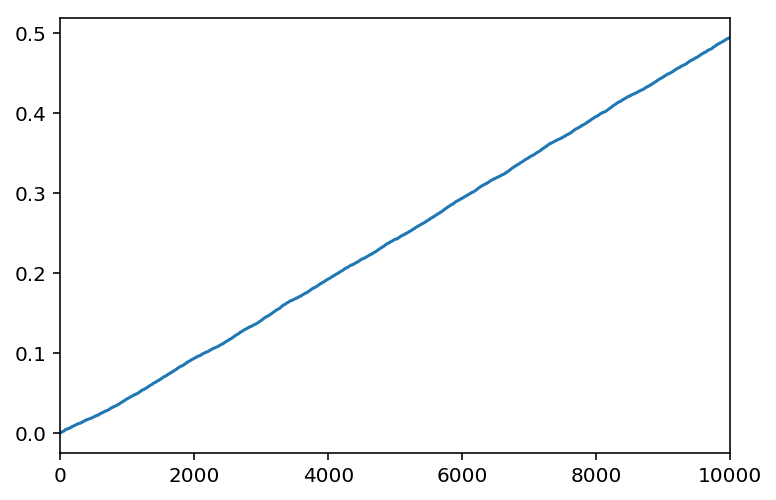

In [7]:
#試行回数
T=10000

#アームの数
armnum=10

#それぞれのアームの正解率(当てたいもの)
ps=[0.2,0.2,0.2,0.2,0.4,0.4,0.4,0.4,0.45,0.5]

#初期値
armparams=np.zeros((armnum,4))
armparams[:,2]=1 #alpha
armparams[:,3]=1 #beta

#実行
thompson_bernoulli(armparams,T,ps).plot()

In [38]:
resultparams=pd.DataFrame(armparams)
resultparams.columns=["win_count","lose_count","alpha","beta"]
resultparams

,win_count,lose_count,alpha,beta
0,5.0,22.0,6.0,23.0
1,3.0,16.0,4.0,17.0
2,5.0,24.0,6.0,25.0
3,8.0,28.0,9.0,29.0
4,128.0,170.0,129.0,171.0
5,105.0,148.0,106.0,149.0
6,38.0,65.0,39.0,66.0
7,61.0,91.0,62.0,92.0
8,78.0,107.0,79.0,108.0
9,4519.0,4378.0,4520.0,4379.0


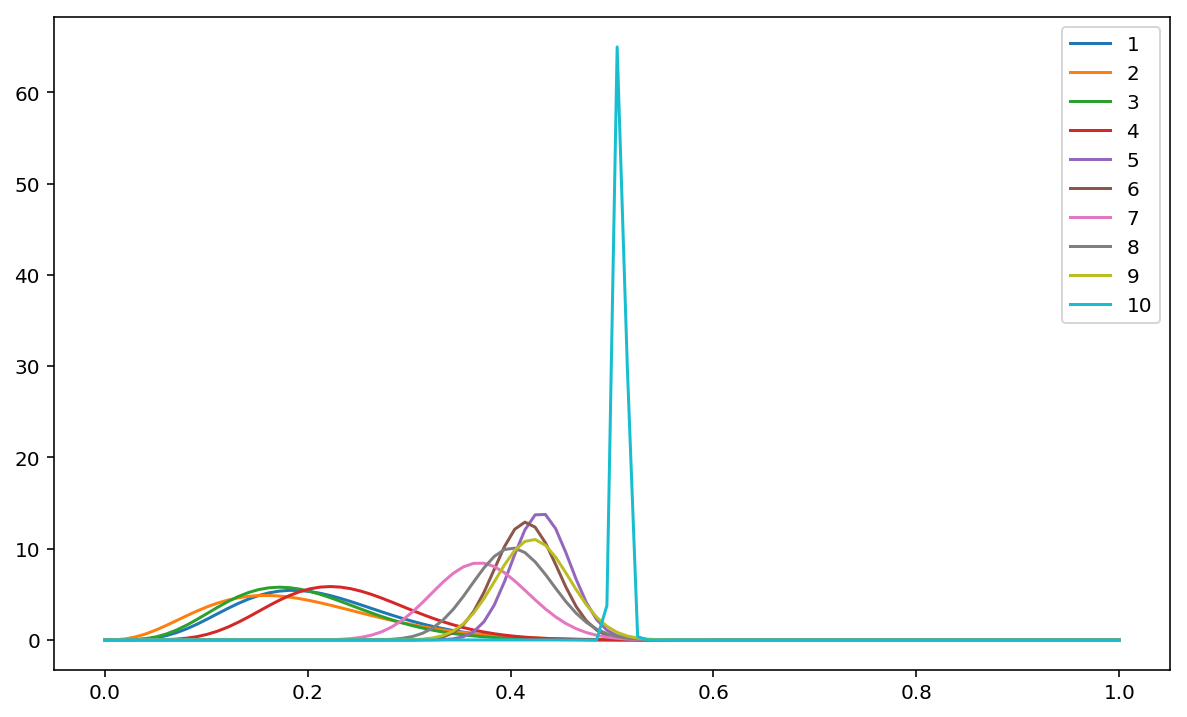

In [19]:
#事後分布
from scipy import stats
x = np.linspace(0,1,100)
plt.figure(figsize=(10,6))
num=1
for a,b in zip(armparams[:,2], armparams[:,3]):
    beta_pdf = stats.beta.pdf(x, a, b)
    plt.plot(x,beta_pdf,label=num)
    num+=1
plt.legend()
plt.show()

# Thompson(平均・分散未知の正規分布の場合)

In [39]:
from scipy.stats import t, norm, gamma

def thompson_gauss(count,m,beta,a,b,T,ps):
    reward=0
    cumulative_reward=[]
    
    """
    #事前にアームを何回か引く場合
    for index in range(len(ps)):
        for _ in range(2):
            #正規分布からランダムサンプリング
            result = norm.rvs(loc=ps[index][0], scale=ps[index][1],size=1)[0]
            
            #パラメータの一時記憶
            bf_m=m[index]
            bf_beta=beta[index]

            #パラメータ更新
            count[index]+=1
            beta[index]=beta[index]+1
            m[index]=(result+bf_beta*m[index])/beta[index]
            a[index]=0.5+a[index]
            b[index]=(result**2+bf_beta*bf_m**2-beta[index]*m[index]**2)/2+b[index]
    """
    
    for i in range(1,T):    
        thetas=[]
        for index in range(len(ps)):
            #事前分布からランダムサンプリング
            lambda_ = gamma.rvs(a[index], loc=0, scale=1/b[index])
            sigma_ = np.sqrt(np.reciprocal(lambda_*beta[index]))
            thetas.append(norm.rvs(loc=m[index], scale=sigma_,size=1)[0])
        
        #print(thetas,max(enumerate(thetas), key=lambda x: x[1])[0])
        
        #パラメータの更新
        index=max(enumerate(thetas), key=lambda x: x[1])[0]
        result = norm.rvs(loc=ps[index][0], scale=ps[index][1],size=1)[0]
        
        bf_m=m[index]
        bf_beta=beta[index]
        
        count[index]+=1
        beta[index]=beta[index]+1
        m[index]=(result+bf_beta*m[index])/beta[index]
        a[index]=0.5+a[index]
        b[index]=(result**2+bf_beta*bf_m**2-beta[index]*m[index]**2)/2+b[index]
        
        reward+=result
        cumulative_reward.append(reward)
    
    return pd.Series(cumulative_reward)/T

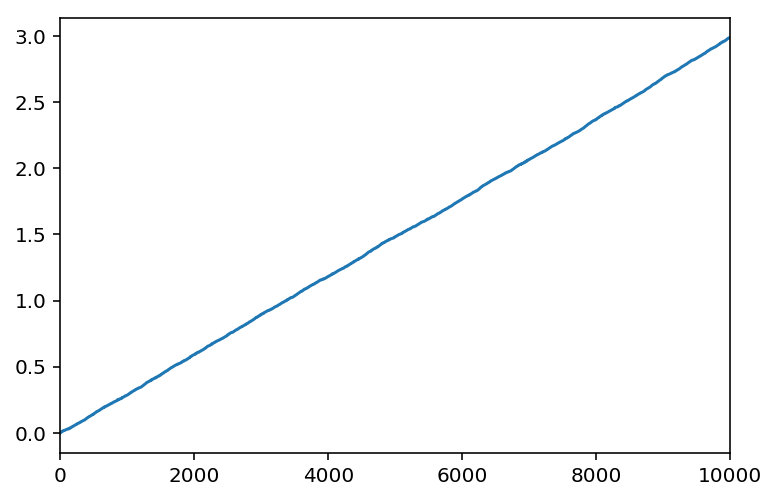

In [40]:
#試行回数
T=10000

#アームの数
armnum=4

#それぞれのアームの平均と分散
ps=[[0,0.3],[0,3],[2,3],[3,3]]

#パラメータ初期値
count=np.zeros(armnum)
m=np.zeros(armnum)
beta=np.ones(armnum)
a=np.ones(armnum)
b=np.ones(armnum)

thompson_gauss(count,m,beta,a,b,T,ps).plot()

In [41]:
#パラメータの確認
params=pd.DataFrame()
params["count"]=count
params["m"]=m
params["beta"]=beta
params["a"]=a
params["b"]=b
params

,count,m,beta,a,b
0,4.0,-0.031187,5.0,3.0,1.137993
1,31.0,0.677457,32.0,16.5,189.478212
2,85.0,1.963307,86.0,43.5,436.629494
3,9879.0,3.005438,9880.0,4940.5,43275.947660


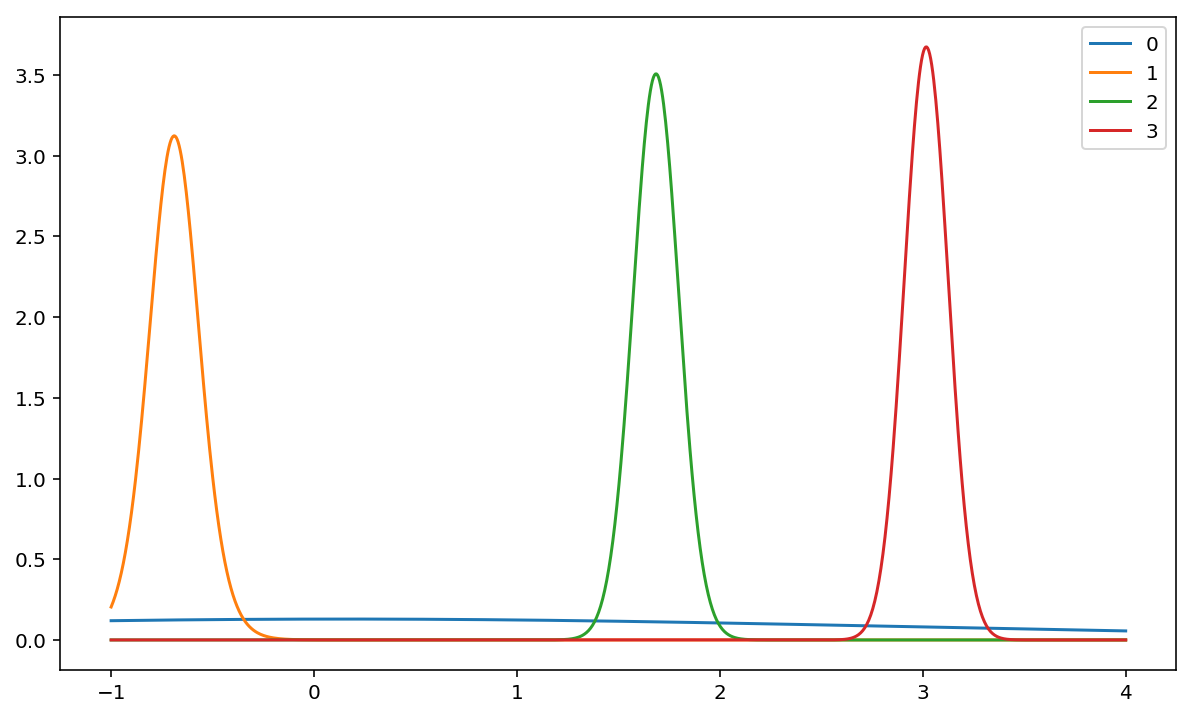

In [34]:
#予測分布
x = np.linspace(-1, 4, 1000)
plt.figure(figsize=(10,6))
for i in range(len(ps)):
    mu_=m[i]
    lambda_=beta[i]*a[i]/((1+beta[i])*b[i])
    neu_=2*a[i]   
    #print(mu_,lambda_,neu_,np.sqrt(np.reciprocal(lambda_)))
    plt.plot(x,t.pdf(x, df=neu_, loc=mu_, scale=lambda_),label=i)
plt.legend()
plt.show()